This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/clutter.html).  I recommend having both windows open, side-by-side!

In [2]:
import sys
print(sys.path)
sys.path.insert(0, "/home/rohanbosworth/manipulation/")


import numpy as np
import random
from pydrake.all import Simulator
from IPython.display import clear_output
from pydrake.all import BasicVector
from manipulation.utils import RenderDiagram
from pydrake.all import (
    AbstractValue,
    AddMultibodyPlantSceneGraph,
    Concatenate,
    DiagramBuilder,
    JointSliders,
    LeafSystem,
    MeshcatPoseSliders,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    PointCloud,
    RandomGenerator,
    Rgba,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
    PiecewisePolynomial,
    PiecewisePose,
    JacobianWrtVariable,
    Quaternion,
)
from manipulation.station import MakeHardwareStation, LoadScenario
from manipulation import running_as_notebook
from manipulation.scenarios import AddFloatingRpyJoint, AddRgbdSensors, ycb
from manipulation.utils import ConfigureParser
import multiprocessing as mp
import os.path
import time
from collections import OrderedDict
from typing import Dict

import numpy as np
import pydot
from IPython.display import SVG, display, display_jpeg, display_pdf, display_png, Image
from pydrake.common.value import AbstractValue
from pydrake.geometry import (
    Meshcat,
    MeshcatVisualizer,
    QueryObject,
    Rgba,
    Role,
    SceneGraph,
    Sphere,
    StartMeshcat,
)
from pydrake.geometry.optimization import (
    HPolyhedron,
    IrisInConfigurationSpace,
    IrisOptions,
    LoadIrisRegionsYamlFile,
    SaveIrisRegionsYamlFile,
)
from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix
from pydrake.multibody.inverse_kinematics import InverseKinematics
from pydrake.multibody.meshcat import JointSliders
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, MultibodyPlant

from pydrake.multibody.tree import Body
from pydrake.solvers import GurobiSolver, MathematicalProgram, Solve
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer
import sys


['/home/rohanbosworth/GCSClutterClearingUpdate/iiwa_setup-main/scripts', '/home/rohanbosworth/GCSClutterClearingUpdate/iiwa_setup-main/scripts/~/manipulation', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/rohanbosworth/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/rohanbosworth/.ipython']


In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [4]:
iris_filename = "my_iris.yaml"
iris_regions = dict()
q = []

# All Helper Functions

## IRIS Region Helpers

In [5]:
# TODO(russt): fetch the an existing yaml using urlretrieve

iris_options = IrisOptions()
iris_options.iteration_limit = 10
# increase num_collision_infeasible_samples to improve the (probabilistic)
# certificate of having no collisions.
iris_options.num_collision_infeasible_samples = 3
iris_options.require_sample_point_is_contained = False
iris_options.relative_termination_threshold = 0.01
iris_options.termination_threshold = -1

# Additional options for this notebook:

# If use_existing_regions_as_obstacles is True, then iris_regions will be
# shrunk by regions_as_obstacles_margin, and then passed to
# iris_options.configuration_obstacles.
use_existing_regions_as_obstacles = False
regions_as_obstacles_scale_factor = 0.95

# We can compute some regions in parallel.
num_parallel = mp.cpu_count()

def ScaleHPolyhedron(hpoly, scale_factor):
    # Shift to the center.
    xc = hpoly.ChebyshevCenter()
    A = hpoly.A()
    b = hpoly.b() - A @ xc
    # Scale
    b = scale_factor * b
    # Shift back
    b = b + A @ xc
    return HPolyhedron(A, b)


def _CheckNonEmpty(region):
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(region.ambient_dimension())
    region.AddPointInSetConstraints(prog, x)
    result = Solve(prog)
    assert result.is_success()


def _CalcRegion(name, seed):
    plant, diagram = LoadRobotHardwareStationWelded()
    robot = plant.GetModelInstanceByName("iiwa")
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    plant.SetPositions(plant_context, robot, seed)
    currPos = plant.GetPositions(plant_context)
    print(currPos)

    diagram.ForcedPublish(diagram_context)

    if use_existing_regions_as_obstacles:
        iris_options.configuration_obstacles = [
            ScaleHPolyhedron(r, regions_as_obstacles_scale_factor)
            for k, r in iris_regions.items()
            if k != name
        ]
        for h in iris_options.configuration_obstacles:
            _CheckNonEmpty(h)
    else:
        iris_options.configuration_obstacles = []
    display(f"Computing region for seed: {name}")
    start_time = time.time()

    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    display(
        f"Finished seed {name}; Computation time: {(time.time() - start_time):.2f} seconds"
    )

    _CheckNonEmpty(hpoly)
    reduced = hpoly.ReduceInequalities()
    _CheckNonEmpty(reduced)

    return reduced



def GenerateRegion(name, seed):
    global iris_regions
    region = _CalcRegion(name, seed)
    iris_regions[name] = _CalcRegion(name, seed)
    SaveIrisRegionsYamlFile(f"{iris_filename}.autosave", iris_regions)


def GenerateRegions(seed_dict, verbose=True):
    if use_existing_regions_as_obstacles:
        # Then run serially
        for k, v in seed_dict.items():
            GenerateRegion(k, v)
        return

    loop_time = time.time()
    with mp.Pool(processes=num_parallel) as pool:
        new_regions = pool.starmap(_CalcRegion, [[k, v] for k, v in seed_dict.items()])

    if verbose:
        print("Loop time:", time.time() - loop_time)

    global iris_regions
    iris_regions.update(dict(list(zip(seed_dict.keys(), new_regions))))


def DrawRobot(query_object: QueryObject, meshcat_prefix: str, draw_world: bool = True):
    rgba = Rgba(0.7, 0.7, 0.7, 0.3)
    role = Role.kProximity
    # This is a minimal replication of the work done in MeshcatVisualizer.
    inspector = query_object.inspector()
    for frame_id in inspector.GetAllFrameIds():
        if frame_id == inspector.world_frame_id():
            if not draw_world:
                continue
            frame_path = meshcat_prefix
        else:
            frame_path = f"{meshcat_prefix}/{inspector.GetName(frame_id)}"
        frame_path.replace("::", "/")
        frame_has_any_geometry = False
        for geom_id in inspector.GetGeometries(frame_id, role):
            path = f"{frame_path}/{geom_id.get_value()}"
            path.replace("::", "/")
            meshcat.SetObject(path, inspector.GetShape(geom_id), rgba)
            meshcat.SetTransform(path, inspector.GetPoseInFrame(geom_id))
            frame_has_any_geometry = True

        if frame_has_any_geometry:
            X_WF = query_object.GetPoseInWorld(frame_id)
            meshcat.SetTransform(frame_path, X_WF)


def VisualizeRegion(region_name, iris_regions,num_to_draw=30, draw_illustration_role_once=True):
    """
    A simple hit-and-run-style idea for visualizing the IRIS regions:
    1. Start at the center. Pick a random direction and run to the boundary.
    2. Pick a new random direction; project it onto the current boundary, and run along it. Repeat
    """

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    LoadRobot(plant)
    plant.Finalize()
    if draw_illustration_role_once:
        MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)

    iris_regions
    region = iris_regions[region_name]

    q = region.ChebyshevCenter()
    plant.SetPositions(plant_context, q)
    diagram.ForcedPublish(context)

    query = scene_graph.get_query_output_port().Eval(scene_graph_context)
    DrawRobot(query, f"{region_name}/0", True)

    rng = np.random.default_rng()
    nq = plant.num_positions()
    prog = MathematicalProgram()
    qvar = prog.NewContinuousVariables(nq, "q")
    prog.AddLinearConstraint(region.A(), 0 * region.b() - np.inf, region.b(), qvar)
    cost = prog.AddLinearCost(np.ones((nq, 1)), qvar)

    for i in range(1, num_to_draw):
        direction = rng.standard_normal(nq)
        cost.evaluator().UpdateCoefficients(direction)

        result = Solve(prog)
        assert result.is_success()

        q = result.GetSolution(qvar)
        plant.SetPositions(plant_context, q)
        query = scene_graph.get_query_output_port().Eval(scene_graph_context)
        DrawRobot(query, f"{region_name}/{i}", False)


def VisualizeRegions():
    for k in iris_regions.keys():
        meshcat.Delete()
        VisualizeRegion(k)
        button_name = f"Visualizing {k}; Press for next region"
        meshcat.AddButton(button_name, "Enter")
        print("Press Enter to visualize the next region")
        while meshcat.GetButtonClicks(button_name) < 1:
            time.sleep(1.0)
        meshcat.DeleteButton(button_name)

def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

# TODO(russt): See https://github.com/RobotLocomotion/drake/pull/19520
class PoseSelector(LeafSystem):
    def __init__(
        self,
        body_index=None,
    ):
        LeafSystem.__init__(self)
        self._body_index = body_index
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()])
        )
        self.DeclareAbstractOutputPort(
            "pose",
            lambda: AbstractValue.Make(RigidTransform()),
            self.CalcOutput,
        )

    def CalcOutput(self, context, output):
        body_poses = self.get_input_port().Eval(context)
        output.set_value(body_poses[self._body_index])

def IrisIndicator(
    iris_regions,
    q
):

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    ee_body = LoadRobot(plant)
    plant.Finalize()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)


    in_any_region = False
    for r in iris_regions.values():
        if r.PointInSet(q):
            if not in_any_region:
                in_any_region = True

    return in_any_region

## Antipodal Grasp Helpers

In [13]:
def GraspCandidateCost(
    diagram,
    context,
    cloud,
    wsg_body_index=None,
    plant_system_name="plant",
    scene_graph_system_name="scene_graph",
    adjust_X_G=False,
    verbose=False,
    meshcat_path=None,
):
    """
    Args:
        diagram: A diagram containing a MultibodyPlant+SceneGraph that contains
            a free body gripper and any obstacles in the environment that we
            want to check collisions against. It should not include the objects
            in the point cloud; those are handled separately.
        context: The diagram context.  All positions in the context will be
            held fixed *except* the gripper free body pose.
        cloud: a PointCloud in world coordinates which represents candidate
            grasps.
        wsg_body_index: The body index of the gripper in plant.  If None, then
            a body named "body" will be searched for in the plant.

    Returns:
        cost: The grasp cost

    If adjust_X_G is True, then it also updates the gripper pose in the plant
    context.
    """
    plant = diagram.GetSubsystemByName(plant_system_name)
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph = diagram.GetSubsystemByName(scene_graph_system_name)
    scene_graph_context = scene_graph.GetMyMutableContextFromRoot(context)
    if wsg_body_index:
        wsg = plant.get_body(wsg_body_index)
    else:
        wsg = plant.GetBodyByName("body")
        wsg_body_index = wsg.index()

    X_G = plant.GetFreeBodyPose(plant_context, wsg)

    # Transform cloud into gripper frame
    X_GW = X_G.inverse()
    p_GC = X_GW @ cloud.xyzs()

    # Crop to a region inside of the finger box.
    crop_min = [-0.05, 0.1, -0.00625]
    crop_max = [0.05, 0.1125, 0.00625]
    indices = np.all(
        (
            crop_min[0] <= p_GC[0, :],
            p_GC[0, :] <= crop_max[0],
            crop_min[1] <= p_GC[1, :],
            p_GC[1, :] <= crop_max[1],
            crop_min[2] <= p_GC[2, :],
            p_GC[2, :] <= crop_max[2],
        ),
        axis=0,
    )

    if meshcat_path:
        pc = PointCloud(np.sum(indices))
        pc.mutable_xyzs()[:] = cloud.xyzs()[:, indices]
        meshcat.SetObject(
            "planning/points", pc, rgba=Rgba(1.0, 0, 0), point_size=0.01
        )

    if adjust_X_G and np.sum(indices) > 0:
        p_GC_x = p_GC[0, indices]
        p_Gcenter_x = (p_GC_x.min() + p_GC_x.max()) / 2.0
        X_G.set_translation(X_G @ np.array([p_Gcenter_x, 0, 0]))
        plant.SetFreeBodyPose(plant_context, wsg, X_G)
        X_GW = X_G.inverse()

    query_object = scene_graph.get_query_output_port().Eval(
        scene_graph_context
    )

    # Check collisions between the gripper and the sink
    if query_object.HasCollisions():
        cost = np.inf
        if verbose:
            print("Gripper is colliding with the sink!\n")
            print(f"cost: {cost}")
        return cost

    distances = query_object.ComputeSignedDistancePairwiseClosestPoints(0.01)
    for dist in distances:
        if (dist.distance < 0.007):
            cost = np.inf
            return cost

    # Check collisions between the gripper and the point cloud
    # must be smaller than the margin used in the point cloud preprocessing.
    margin = 0.0
    for i in range(cloud.size()):
        distances = query_object.ComputeSignedDistanceToPoint(
            cloud.xyz(i), threshold=margin
        )
        if distances:
            cost = np.inf
            if verbose:
                print("Gripper is colliding with the point cloud!\n")
                print(f"cost: {cost}")
            return cost

    n_GC = X_GW.rotation().multiply(cloud.normals()[:, indices])

    # Penalize deviation of the gripper from vertical.
    # weight * -dot([0, 0, -1], R_G * [0, 1, 0]) = weight * R_G[2,1]
    cost = 20.0 * X_G.rotation().matrix()[2, 1]

    # Reward sum |dot product of normals with gripper x|^2
    cost -= np.sum(n_GC[0, :] ** 2)
    if verbose:
        print(f"cost: {cost}")
        print(f"normal terms: {n_GC[0,:]**2}")
    return cost


class ScoreSystem(LeafSystem):
    def __init__(self, diagram, cloud, wsg_pose_index):
        LeafSystem.__init__(self)
        self._diagram = diagram
        self._context = diagram.CreateDefaultContext()
        self._plant = diagram.GetSubsystemByName("plant")
        self._plant_context = self._plant.GetMyMutableContextFromRoot(
            self._context
        )
        wsg = self._plant.GetBodyByName("body")
        self._wsg_body_index = wsg.index()
        self._wsg_pose_index = wsg_pose_index
        self._cloud = cloud
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()])
        )
        self.DeclareForcedPublishEvent(self.Publish)

    def Publish(self, context):
        X_WG = self.get_input_port(0).Eval(context)[self._wsg_pose_index]
        self._plant.SetFreeBodyPose(
            self._plant_context,
            self._plant.get_body(self._wsg_body_index),
            X_WG,
        )
        GraspCandidateCost(
            self._diagram,
            self._context,
            self._cloud,
            verbose=True,
            meshcat_path="planning/cost",
        )
        clear_output(wait=True)
        
stackTime = 0
currTraj = 0
        
class TrajPosOut(LeafSystem):
    def __init__(self, plant, traj):
        LeafSystem.__init__(self)
        self.traje = traj
        self.plant = plant
        self.plant_context = self.plant.CreateDefaultContext()
        self.gripper = self.plant.GetModelInstanceByName("wsg")
        
        self.DeclareVectorOutputPort("iiwa_position", BasicVector(7), self.calciiwaPos)
        self.DeclareVectorOutputPort("plan_stage", BasicVector(1), self.getI)
        self.currTraj = 0
        self.stackTime = 0
        self.outTraj = 0
                                     
    def getI(self, context, output):
        output.SetFromVector([self.outTraj])
        
    def calciiwaPos(self, context, output):
        if (context.get_time() < 0.1):
            self.currTraj = 0
            self.stackTime = 0
            self.outTraj = 0
        if (context.get_time() > self.traje[self.currTraj].end_time() + self.stackTime):
            self.stackTime += self.traje[self.currTraj].end_time()
            self.outTraj += 1
            if self.currTraj < len(self.traje) - 1:
                self.currTraj += 1
            else:
                self.stackTime = 0
        if self.currTraj == 1:
            linMoveTrajPos = linMoveTraj.get_position_trajectory()
            linMoveTrajAng = linMoveTraj.get_orientation_trajectory()
            X_G = RigidTransform(Quaternion(linMoveTrajAng.value(context.get_time() - self.stackTime)), linMoveTrajPos.value(context.get_time() - self.stackTime))
            output.SetFromVector(MyInverseKinematics(X_G, self.plant, self.plant_context, self.gripper)[0:7])
        else:
            output.SetFromVector(self.traje[self.currTraj].value(context.get_time() - self.stackTime))
        
        return
        
        if (context.get_time() > self.traje[0].end_time() + self.traje[1].end_time()):
            self.i = 0
        elif (context.get_time() > self.traje[0].end_time()):
            output.SetFromVector(self.traje[1].value(context.get_time() - self.traje[0].end_time()))
            self.i = 1
        else:
            output.SetFromVector(self.traje[0].value(context.get_time()))
            self.i = 0
        
        
class WSGOut(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self.DeclareVectorOutputPort("wsg_position", BasicVector(1), self.calciiwaPos)
        self.statusTime = self.DeclareVectorInputPort("statusTime", 1)
        
    def calciiwaPos(self, context, output):
        if self.statusTime.Eval(context)[0] == 2:
            output.SetFromVector([-0.5])
        else:
            output.SetFromVector([0.5])

        
        
def make_environment_model_display(
    traj, directive=None, draw=True, rng=None, num_ycb_objects=0, bin_name="bin0"
) -> Body:
    # Make one model of the environment, but the robot only gets to see the sensor outputs.

    builder = DiagramBuilder()
    
    obj = None
    print(ycb)
    
    '''
    for i in range(num_ycb_objects):
        object_num = rng.integers(len(ycb))
        obj = parser.AddModelsFromUrl(
            f"package://manipulation/hydro/{ycb[object_num]}"
        )
    parser.package_map().AddRemote(
        package_name="gcs",
        params=PackageMap.RemoteParams(
            urls=[
                f"https://github.com/mpetersen94/gcs/archive/refs/tags/arxiv_paper_version.tar.gz"
            ],
            sha256=("6dd5e841c8228561b6d622f592359c36517cd3c3d5e1d3e04df74b2f5435680c"),
            strip_prefix="gcs-arxiv_paper_version",
        ),
    )
    '''
    
    model_directives = """    
directives:

- add_directives:
    file: package://manipulation/clutter.dmd.yaml
    
- add_model:
    name: foam_brick1
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [-0.17, -0.6, 0.05]
- add_model:
    name: foam_brick2
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [-0.18, -0.5, 0.05]
            
- add_model:
     name: meatCan
     file: package://manipulation/hydro/010_potted_meat_can.sdf
     default_free_body_pose:
         base_link_meat:
             translation: [-0.05, -0.45, 0.05]
            
- add_model:
     name: pickObject
     file: package://manipulation/hydro/004_sugar_box.sdf
     default_free_body_pose:
         base_link_sugar:
             translation: [0.05, -0.55, 0.05]
             rotation: !Rpy { deg: [0.0, 90.0, 0.0 ]}
     
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
    """

    scenario = LoadScenario(data=model_directives)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat))
    
    plant = station.GetSubsystemByName("plant")
    
    scene_graph = station.GetSubsystemByName("scene_graph")
    
    robot = plant.GetModelInstanceByName("iiwa")

    extraGrip = plant.GetModelInstanceByName("wsg")
    obj = plant.GetModelInstanceByName("pickObject")
    #plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body", extraGrip), xyz_rpy_deg([0, 0, 0], [0, 0, 0]))

    gripper = plant.GetModelInstanceByName("wsg")
    end_effector_body = plant.GetBodyByName("body", gripper)
       
    AddRgbdSensors(builder, plant, scene_graph)
    
    iiwa_controller = builder.AddSystem(TrajPosOut(plant, traj))
    iiwa_controller.set_name("iiwa_controller")
    
    wsg_controller = builder.AddSystem(WSGOut(plant))
    wsg_controller.set_name("wsg_controller")
    
    outPort = iiwa_controller.GetOutputPort("iiwa_position")
    
    builder.Connect(wsg_controller.GetOutputPort("wsg_position"), station.GetInputPort("wsg.position"),)
    
    builder.Connect(iiwa_controller.GetOutputPort("iiwa_position"), station.GetInputPort("iiwa.position"),)
    
    builder.Connect(iiwa_controller.GetOutputPort("plan_stage"), wsg_controller.GetInputPort("statusTime"))

    diagram = builder.Build()
    #RenderDiagram(diagram)
    
    #simulator = Simulator(diagram)
    #simulator.set_target_realtime_rate(0.1)
    #simulator.AdvanceTo(2.0)
    context = diagram.CreateDefaultContext()

    objPos = [0]
    
    if num_ycb_objects > 0:
        generator = RandomGenerator(rng.integers(1000))  # this is for c++
        plant_context = plant.GetMyContextFromRoot(context)
        bin_instance = plant.GetModelInstanceByName(bin_name)
        bin_body = plant.GetBodyByName("bin_base", bin_instance)
        X_B = plant.EvalBodyPoseInWorld(plant_context, bin_body)
        z = 0.2
        for body_index in plant.GetFloatingBaseBodies():
            tf = RigidTransform(
                UniformlyRandomRotationMatrix(generator),
                [rng.uniform(-0.15, 0.15), rng.uniform(-0.2, 0.2), z],
            )
            '''
            plant.SetFreeBodyPose(
                plant_context, plant.get_body(body_index), X_B.multiply(tf)
            )
            z += 0.1
            '''
        simulator = Simulator(diagram, context)
        simulator.AdvanceTo(2.0 if running_as_notebook else 0.1)
        objPos = plant.GetPositions(plant_context, obj)
    elif draw:
        diagram.ForcedPublish(context)
    diagram.ForcedPublish(context)
        
    return diagram, context, robot, objPos, obj, outPort, plant


def process_point_cloud(diagram, context, cameras, bin_name):
    plant = diagram.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    # Compute crop box.
    bin_instance = plant.GetModelInstanceByName(bin_name)
    bin_body = plant.GetBodyByName("bin_base", bin_instance)
    X_B = plant.EvalBodyPoseInWorld(plant_context, bin_body)
    margin = 0.001  # only because simulation is perfect!
    a = X_B.multiply(
        [-0.22 + 0.025 + margin, -0.29 + 0.025 + margin, 0.015 + margin]
    )
    b = X_B.multiply([0.22 - 0.1 - margin, 0.29 - 0.025 - margin, 2.0])
    crop_min = np.minimum(a, b)
    crop_max = np.maximum(a, b)

    pcd = []
    for i in range(3):
        cloud = diagram.GetOutputPort(f"{cameras[i]}_point_cloud").Eval(
            context
        )

        # Crop to region of interest.
        pcd.append(cloud.Crop(lower_xyz=crop_min, upper_xyz=crop_max))
        # Estimate normals
        pcd[i].EstimateNormals(radius=0.1, num_closest=30)

        # Flip normals toward camera
        camera = plant.GetModelInstanceByName(f"camera{i}")
        body = plant.GetBodyByName("base", camera)
        X_C = plant.EvalBodyPoseInWorld(plant_context, body)
        pcd[i].FlipNormalsTowardPoint(X_C.translation())

    # Merge point clouds.
    merged_pcd = Concatenate(pcd)

    # Voxelize down-sample.  (Note that the normals still look reasonable)
    return merged_pcd.VoxelizedDownSample(voxel_size=0.005)


def make_environment_model(
    directive=None, draw=False, rng=None, num_ycb_objects=0, bin_name="bin0", plant=None, scene_graph=None, builder=None
) -> Body:
    # Make one model of the environment, but the robot only gets to see the sensor outputs.
    if not directive:
        directive = "package://manipulation/clutter_planning.dmd.yaml"

    #builder = DiagramBuilder()
    #plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0005)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.SetAutoRenaming(True)
    parser.AddModelsFromUrl(directive)
    obj = []

    for i in range(num_ycb_objects):
        object_num = rng.integers(len(ycb))
        continue
        obj = parser.AddModelsFromUrl(
            f"package://manipulation/hydro/{ycb[object_num]}"
        )

    parser.package_map().AddRemote(
        package_name="gcs",
        params=PackageMap.RemoteParams(
            urls=[
                f"https://github.com/mpetersen94/gcs/archive/refs/tags/arxiv_paper_version.tar.gz"
            ],
            sha256=("6dd5e841c8228561b6d622f592359c36517cd3c3d5e1d3e04df74b2f5435680c"),
            strip_prefix="gcs-arxiv_paper_version",
        ),
    )
    
    can_directives = """
    
directives:

- add_model:
     name: pickObject
     file: package://manipulation/hydro/010_potted_meat_can.sdf
     default_free_body_pose:
         base_link_meat:
             translation: [-0.05, -0.45, 0.05]
            """
    
    brick_directives = """
directives:

- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [-0.17, -0.6, 0.05]
- add_model:
    name: foam_brick
    file: package://manipulation/hydro/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [-0.18, -0.5, 0.05]

            """
    sugar_directives = """
directives:

- add_model:
     name: pickObject
     file: package://manipulation/hydro/004_sugar_box.sdf
     default_free_body_pose:
         base_link_sugar:
             translation: [0.15, -0.5, 0.05]
             rotation: !Rpy { deg: [0.0, 90.0, 0.0 ]}
    """
    
    model_directives = """    
directives:

# Add iiwa
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.8]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1]
        iiwa_joint_7: [1.57]

- add_weld:
    parent: world
    child: iiwa::base

# Add schunk
- add_model:
    name: wsg
    file: package://drake_models/wsg_50_description/sdf/schunk_wsg_50.sdf

- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
      translation: [0, 0, 0.114]
      rotation: !Rpy { deg: [90.0, 0.0, 90.0 ]}

"""

    robot = parser.AddModelsFromString(model_directives, ".dmd.yaml")
    obj.append(parser.AddModelsFromString(sugar_directives, ".dmd.yaml"))
    #obj.append(parser.AddModelsFromString(brick_directives, ".dmd.yaml"))
    #obj.append(parser.AddModelsFromString(can_directives, ".dmd.yaml"))

    extraGrip = plant.GetModelInstanceByName("gripper")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body", extraGrip), xyz_rpy_deg([0, 0, 0], [0, 0, 0]))

    gripper = plant.GetModelInstanceByName("wsg")
    end_effector_body = plant.GetBodyByName("body", gripper)
    
    plant.Finalize()
    AddRgbdSensors(builder, plant, scene_graph)

    if draw:
        MeshcatVisualizer.AddToBuilder(
            builder,
            scene_graph,
            meshcat,
            MeshcatVisualizerParams(prefix="environment"),
        )

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    objPos = None
    
    sim = Simulator(diagram, context)
    sim.AdvanceTo(2.0)
    
    return diagram, context, robot, objPos, obj[0]

    if num_ycb_objects > 0:
        generator = RandomGenerator(rng.integers(1000))  # this is for c++
        plant_context = plant.GetMyContextFromRoot(context)
        bin_instance = plant.GetModelInstanceByName(bin_name)
        bin_body = plant.GetBodyByName("bin_base", bin_instance)
        X_B = plant.EvalBodyPoseInWorld(plant_context, bin_body)
        z = 0.2
        for body_index in plant.GetFloatingBaseBodies():
            tf = RigidTransform(
                UniformlyRandomRotationMatrix(generator),
                [rng.uniform(-0.15, 0.15), rng.uniform(-0.2, 0.2), z],
            )
            '''
            plant.SetFreeBodyPose(
                plant_context, plant.get_body(body_index), X_B.multiply(tf)
            )
            z += 0.1
            '''

        simulator = Simulator(diagram, context)
        simulator.AdvanceTo(2.0 if running_as_notebook else 0.1)
        objPos = plant.GetPositions(plant_context, obj[0])
    elif draw:
        diagram.ForcedPublish(context)
    diagram.ForcedPublish(context)
    return diagram, context, robot, objPos, obj[0]


# Another diagram for the objects the robot "knows about": gripper, cameras, bins.  Think of this as the model in the robot's head.
def make_internal_model():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl("package://manipulation/clutter_planning.dmd.yaml")
    plant.Finalize()
    return builder.Build()

# Sometimes it's useful to use inverse kinematics to find the seeds. You might
# need to adapt this to your robot. This helper takes an end-effector frame, E,
# and a desired pose for that frame in the world coordinates, X_WE.
def MyInverseKinematics(X_WE, plant=None, context=None, gripper=None):
    if not plant:
        plant = MultibodyPlant(0.0)
        #ee_body = LoadRobot(plant)
        plant.Finalize()
    if not context:
        context = plant.CreateDefaultContext()
    # E = ee_body.body_frame()
    E = plant.GetBodyByName("body", gripper).body_frame()

    ik = InverseKinematics(plant, context)

    ik.AddPositionConstraint(
        E, [0, 0, 0], plant.world_frame(), X_WE.translation(), X_WE.translation()
    )

    ik.AddOrientationConstraint(
        E, RotationMatrix(), plant.world_frame(), X_WE.rotation(), 0.001
    )

    prog = ik.get_mutable_prog()
    q = ik.q()

    q0 = plant.GetPositions(context)
    prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
    prog.SetInitialGuess(q, q0)
    result = Solve(ik.prog())
    if not result.is_success():
        print("IK failed")
        return None
    plant.SetPositions(context, result.GetSolution(q))
    return result.GetSolution(q)

def grasp_score_inspector():
    meshcat.Delete()
    environment, environment_context = make_environment_model(
        directive="package://manipulation/clutter_mustard.dmd.yaml", draw=True
    )

    internal_model = make_internal_model()

    # Finally, we'll build a diagram for running our visualization
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl("package://manipulation/clutter_planning.dmd.yaml")
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName("body"),
        plant.GetModelInstanceByName("gripper"),
    )
    plant.Finalize()

    meshcat.DeleteAddedControls()
    params = MeshcatVisualizerParams()
    params.prefix = "planning"
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat, params
    )

    cloud = process_point_cloud(
        environment,
        environment_context,
        ["camera0", "camera1", "camera2"],
        "bin0",
    )
    meshcat.SetObject("planning/cloud", cloud, point_size=0.003)

    score = builder.AddSystem(
        ScoreSystem(internal_model, cloud, plant.GetBodyByName("body").index())
    )
    builder.Connect(plant.get_body_poses_output_port(), score.get_input_port())

    lower_limit = [-1, -1, 0, -np.pi, -np.pi / 4.0, -np.pi / 4.0]
    upper_limit = [1, 1, 1, 0, np.pi / 4.0, np.pi / 4.0]
    q0 = [-0.05, -0.5, 0.25, -np.pi / 2.0, 0, 0]
    default_interactive_timeout = None if running_as_notebook else 1.0
    sliders = builder.AddSystem(
        JointSliders(
            meshcat,
            plant,
            initial_value=q0,
            lower_limit=lower_limit,
            upper_limit=upper_limit,
            decrement_keycodes=[
                "KeyQ",
                "KeyS",
                "KeyA",
                "KeyJ",
                "KeyK",
                "KeyU",
            ],
            increment_keycodes=[
                "KeyE",
                "KeyW",
                "KeyD",
                "KeyL",
                "KeyI",
                "KeyO",
            ],
        )
    )
    diagram = builder.Build()
    sliders.Run(diagram, default_interactive_timeout)
    meshcat.DeleteAddedControls()


def draw_grasp_candidate(X_G, prefix="gripper", draw_frames=True):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl(
        "package://manipulation/schunk_wsg_50_welded_fingers.sdf"
    )
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body"), X_G)
    plant.Finalize()

    # frames_to_draw = {"gripper": {"body"}} if draw_frames else {}
    params = MeshcatVisualizerParams()
    params.prefix = prefix
    params.delete_prefix_on_initialization_event = False
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat, params
    )
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)


def GenerateAntipodalGraspCandidate(
    diagram,
    context,
    cloud,
    rng,
    wsg_body_index=None,
    plant_system_name="plant",
    scene_graph_system_name="scene_graph",
):
    """
    Picks a random point in the cloud, and aligns the robot finger with the normal of that pixel.
    The rotation around the normal axis is drawn from a uniform distribution over [min_roll, max_roll].
    Args:
        diagram: A diagram containing a MultibodyPlant+SceneGraph that contains
            a free body gripper and any obstacles in the environment that we
            want to check collisions against. It should not include the objects
            in the point cloud; those are handled separately.
        context: The diagram context.  All positions in the context will be
            held fixed *except* the gripper free body pose.
        cloud: a PointCloud in world coordinates which represents candidate
            grasps.
        rng: a np.random.default_rng()
        wsg_body_index: The body index of the gripper in plant.  If None, then
            a body named "body" will be searched for in the plant.

    Returns:
        cost: The grasp cost
        X_G: The grasp candidate
    """
    plant = diagram.GetSubsystemByName(plant_system_name)
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph = diagram.GetSubsystemByName(scene_graph_system_name)
    scene_graph.GetMyMutableContextFromRoot(context)
    if wsg_body_index:
        wsg = plant.get_body(wsg_body_index)
    else:
        wsg = plant.GetBodyByName("body")
        wsg_body_index = wsg.index()

    index = rng.integers(0, cloud.size() - 1)

    # Use S for sample point/frame.
    p_WS = cloud.xyz(index)
    n_WS = cloud.normal(index)

    assert np.isclose(
        np.linalg.norm(n_WS), 1.0
    ), f"Normal has magnitude: {np.linalg.norm(n_WS)}"

    Gx = n_WS  # gripper x axis aligns with normal
    # make orthonormal y axis, aligned with world down
    y = np.array([0.0, 0.0, -1.0])
    if np.abs(np.dot(y, Gx)) < 1e-6:
        # normal was pointing straight down.  reject this sample.
        return np.inf, None

    Gy = y - np.dot(y, Gx) * Gx
    Gz = np.cross(Gx, Gy)
    R_WG = RotationMatrix(np.vstack((Gx, Gy, Gz)).T)
    p_GS_G = [0.054 - 0.01, 0.10625, 0]

    # Try orientations from the center out
    min_roll = -np.pi / 3.0
    max_roll = np.pi / 3.0
    alpha = np.array([0.5, 0.65, 0.35, 0.8, 0.2, 1.0, 0.0])
    for theta in min_roll + (max_roll - min_roll) * alpha:
        # Rotate the object in the hand by a random rotation (around the normal).
        R_WG2 = R_WG.multiply(RotationMatrix.MakeXRotation(theta))

        # Use G for gripper frame.
        p_SG_W = -R_WG2.multiply(p_GS_G)
        p_WG = p_WS + p_SG_W

        X_G = RigidTransform(R_WG2, p_WG)
        plant.SetFreeBodyPose(plant_context, wsg, X_G)
        cost = GraspCandidateCost(diagram, context, cloud, adjust_X_G=True, verbose=False)
        X_G = plant.GetFreeBodyPose(plant_context, wsg)
        if np.isfinite(cost):
            return cost, X_G

        # draw_grasp_candidate(X_G, f"collision/{theta:.1f}")

    return np.inf, None

In [22]:
import pickle
usedRegions = [None]
    

# Sometimes it's useful to use inverse kinematics to find the seeds. You might
# need to adapt this to your robot. This helper takes an end-effector frame, E,
# and a desired pose for that frame in the world coordinates, X_WE.
def MyInverseKinematicsRegions(X_WE, plant=None, context=None, gripper=None, regions = None):
    regionsss = regions.keys()
    for key in regionsss:
        reg = regions[key]
        plant, diagram = LoadRobotHardwareStation()

        root_context = diagram.CreateDefaultContext()
        
        context = plant.GetMyContextFromRoot(root_context)
        # E = ee_body.body_frame()
        gripper = plant.GetModelInstanceByName("wsg")
        E = plant.GetBodyByName("body", gripper).body_frame()

        ik = InverseKinematics(plant, context)

        ik.AddPositionConstraint(
            E, [0, 0, 0], plant.world_frame(), X_WE.translation(), X_WE.translation()
        )

        ik.AddOrientationConstraint(
            E, RotationMatrix(), plant.world_frame(), X_WE.rotation(), 0.001
        )

        prog = ik.get_mutable_prog()
        q = ik.q()
        
        
        plant_context = plant.GetMyContextFromRoot(root_context)
        
        robot = plant.GetModelInstanceByName("iiwa")
                
        diagram.ForcedPublish(root_context)

        print(q.size)
        
        reg.AddPointInSetConstraints(prog, q)

        q0 = plant.GetPositions(context)
        prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
        prog.SetInitialGuess(q, q0)
        result = Solve(ik.prog())
        if result.is_success():
            plant.SetPositions(context, result.GetSolution(q))
            return result.GetSolution(q)
    
    return None

## Robot Helpers

In [8]:
# Note: The order of the seeds matters when we are using existing regions as
# configuration_obstacles.
seeds = OrderedDict()

seeds["ZeroedPosition"] = [0, 0, 0, 0, 0, 0, 0]
seeds["Above Bin 2"] = [0, 0.3, 0, -1.8, 0, 1, 1.57]
seeds["In Bin 2"] = [0, 0.48, 0, -1.88, 0, 0.67, 1.57]
seeds["In Bin 1"] = [-1.56, 0.62, 0, -1.74, 0, 0.67, 1.57]
seeds["Above Bin 1"] = [-1.57, 0.3, 0, -1.8, 0, 1, 1.57]

seeds["Between Bins"] = [-0.785, 0.3, 0, -1.8, 0, 1, 1.57]
seeds["Transition"] = [-0.75, -0.61, 0, -1.8, 0, 1, 1.57]

#seeds.update(pickPoses)


In [15]:
def LoadRobot(plant: MultibodyPlant) -> Body:
    parser = Parser(plant)
    ConfigureParser(parser)
    parser.AddModelsFromUrl("package://manipulation/clutter_planning.dmd.yaml")
    # We'll use some tables, shelves, and bins from a remote resource.
    parser.package_map().AddRemote(
        package_name="gcs",
        params=PackageMap.RemoteParams(
            urls=[
                f"https://github.com/mpetersen94/gcs/archive/refs/tags/arxiv_paper_version.tar.gz"
            ],
            sha256=("6dd5e841c8228561b6d622f592359c36517cd3c3d5e1d3e04df74b2f5435680c"),
            strip_prefix="gcs-arxiv_paper_version",
        ),
    )

    
    model_directives = """    
directives:

# Add iiwa
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.8]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1]
        iiwa_joint_7: [1.57]

- add_weld:
    parent: world
    child: iiwa::base

# Add schunk
- add_model:
    name: wsg
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_welded_fingers.sdf

- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
      translation: [0, 0, 0.114]
      rotation: !Rpy { deg: [90.0, 0.0, 0.0 ]}

"""

    parser.AddModelsFromString(model_directives, ".dmd.yaml")

    extraGrip = plant.GetModelInstanceByName("gripper")
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("body", extraGrip), xyz_rpy_deg([0, 0, 0], [0, 0, 0]))

    gripper = plant.GetModelInstanceByName("wsg")
    end_effector_body = plant.GetBodyByName("body", gripper)

meshcat2 = StartMeshcat()

    
def LoadRobotHardwareStation(builder = None):
    if not builder:
        builder = DiagramBuilder()
    
    model_directives = """    
directives:
- add_directives:
    file: package://manipulation/two_bins.dmd.yaml

- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.8]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1]
        iiwa_joint_7: [1.57]

- add_weld:
    parent: world
    child: iiwa::base

# Add schunk
- add_model:
    name: wsg
    file: package://drake_models/wsg_50_description/sdf/schunk_wsg_50_welded_fingers.sdf

- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
      translation: [0, 0, 0.114]
      rotation: !Rpy { deg: [90.0, 0.0, 90.0 ]}
    """

    scenario = LoadScenario(data=model_directives)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat = meshcat2))
    
    plant = station.GetSubsystemByName("plant")
    
    
    diagram = builder.Build()

    diagram.ForcedPublish(diagram.CreateDefaultContext())
    
    return plant, diagram


def LoadRobotHardwareStationWelded(builder = None):
    if not builder:
        builder = DiagramBuilder()
    
    model_directives = """    
directives:
- add_directives:
    file: package://manipulation/two_bins.dmd.yaml

# Add iiwa
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.3]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.8]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1]
        iiwa_joint_7: [1.57]

- add_weld:
    parent: world
    child: iiwa::base

# Add schunk
- add_model:
    name: wsg
    file: package://drake/manipulation/models/wsg_50_description/sdf/schunk_wsg_50_welded_fingers.sdf

- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
      translation: [0, 0, 0.114]
      rotation: !Rpy { deg: [90.0, 0.0, 0.0 ]}
    """

    scenario = LoadScenario(data=model_directives)
    station = builder.AddSystem(MakeHardwareStation(scenario, meshcat = meshcat2))
    
    plant = station.GetSubsystemByName("plant")
    
    
    diagram = builder.Build()
    
    return plant, diagram


INFO:drake:Meshcat listening for connections at http://localhost:7003


In [10]:
if os.path.isfile(iris_filename):
    iris_regions.update(LoadIrisRegionsYamlFile(iris_filename))
    print(f"Loaded iris regions from {iris_filename}.")

Loaded iris regions from my_iris.yaml.


## GCS Helpers

In [11]:
from pydrake.planning import GcsTrajectoryOptimization
from pydrake.geometry.optimization import Point, GraphOfConvexSetsOptions


def PublishPositionTrajectory(
    trajectorys, root_context, plant, visualizer, context, objPos, obj, diagram, time_step=1.0 / 33.0
):
    """
    Args:
        trajectory: A Trajectory instance.
    """
    plant_context = plant.GetMyContextFromRoot(root_context)
    outSys = diagram.GetSubsystemByName("iiwa_controller")
    #visualizer_context = visualizer.GetMyContextFromRoot(root_context)

    #plant.SetPositions(plant_context, gripperI, [-0.055, 0.055])
    #plant.SetPositions(plant_context, obj, objPos)
    #plant.SetPositions(plant_context, context, trajectorys[0].value(0))
    #diagramI.ForcedPublish(root_context)
    first = 0
    
    sim = Simulator(diagram)
        
    currTime = 0.05
    sim.set_target_realtime_rate(0.1)
    sim.AdvanceTo(2.0)

    #visualizer.StartRecording(True)
    tOld = 0

    for trajectory in trajectorys:

        for t in np.append(
            np.arange(trajectory.start_time(), trajectory.end_time(), time_step),
            trajectory.end_time(),
        ):
            #visualizer_context = visualizer.GetMyContextFromRoot(root_context)
            plant_context = plant.GetMyContextFromRoot(sim.get_context())
            outContext = outSys.GetMyContextFromRoot(sim.get_context())
            print(sim.get_context().get_time())
            print("plant" + str(plant.get_actuation_input_port(robot[0]).Eval(plant_context)))
            print("out" + str(outPort.Eval(outContext)))
            print("plantPos" + str(plant.GetPositions(plant_context, robot[0])))
            
            currTime = currTime + 0.05
            sim.AdvanceTo(currTime)
            
            #root_context.SetTime(t)
            #plant.SetPositions(plant_context, context, trajectory.value(t))
            
            if first >= 1:
                continue
                plant.SetPositions(plant_context, gripperI, [0, 0])
            
            #sim.AdvanceTo(0.01)
            #visualizer.ForcedPublish(visualizer_context)
            #diagramI.ForcedPublish(root_context)
            first += 1
            tOld = t

    #visualizer.StopRecording()
    #visualizer.PublishRecording()


def GcsTrajOpt(q_start, q_goal, plantI, diagramI, contextI, objPos, obj):
    if not iris_regions:
        print(
            "No IRIS regions loaded. Make some IRIS regions then come back and try this again."
        )
        return
    assert len(q_start) == len(q_goal)
    assert len(q_start) == iris_regions[next(iter(iris_regions))].ambient_dimension()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    LoadRobot(plant)
    plant.Finalize()
    #AddDefaultVisualization(builder, meshcat)
    #diagram = builder.Build()
    edges = []

    gcs = GcsTrajectoryOptimization(len(q_start))
    # TODO(russt): AddRegions should take named regions.
    regions = gcs.AddRegions(list(iris_regions.values()), order=1)
    source = gcs.AddRegions([Point(q_start)], order=0)
    target = gcs.AddRegions([Point(q_goal)], order=0)
    edges.append(gcs.AddEdges(source, regions))
    edges.append(gcs.AddEdges(regions, target))
    
    gcs.AddTimeCost()
    gcs.AddVelocityBounds(
        plant.GetVelocityLowerLimits(), (plant.GetVelocityUpperLimits() * 0.25)
    )
    

    options = GraphOfConvexSetsOptions()
    options.preprocessing = True
    options.max_rounded_paths = 5
    start_time = time.time()
    print("Running GCS")
    traj, result = gcs.SolvePath(source, target, options)
    print(f"GCS solved in {time.time() - start_time} seconds")
    if not result.is_success():
        print("Could not find a feasible path from q_start to q_goal")
        return
    
    return traj
    
    for edge in gcs.graph_of_convex_sets().Edges():
        print(result.GetSolution(edge.phi()))
        
    


# Generating grasp candidates

In [23]:
def sample_grasps_example():
    meshcat.Delete()
    rng = np.random.default_rng()
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0005)

    diagram, context, robot, objPos, obj = make_environment_model(
        rng=rng, num_ycb_objects=1, draw=True, plant=plant, scene_graph = scene_graph, builder=builder
    )

    internal_model = make_internal_model()
    internal_model_context = internal_model.CreateDefaultContext()

    diagram.ForcedPublish(context)

    # Hide the planning gripper
    meshcat.SetProperty("planning/gripper", "visible", False)

    cloud = process_point_cloud(
        diagram,
        context,
        ["camera0", "camera1", "camera2"],
        "bin0",
    )
    #meshcat.SetObject("planning/cloud", cloud, point_size=0.003)

    plant_context = plant.GetMyContextFromRoot(context)
    scene_graph.GetMyContextFromRoot(context)


    costs = []
    X_Gs = []
    for i in range(200 if running_as_notebook else 2):
        cost, X_G = GenerateAntipodalGraspCandidate(
            internal_model, internal_model_context, cloud, rng
        )
        if np.isfinite(cost):
            costs.append(cost)
            X_Gs.append(X_G)

    retList = []

    minInd = np.argmin(costs)
    
    import random
    
    #minInd = random.randint(0, len(costs))    
    
    retList.append(X_Gs[minInd])
    
    draw_grasp_candidate(
            X_Gs[minInd], prefix=f"{1}th best", draw_frames=False
    )
    
    return retList, plant, diagram, robot, objPos, obj    

    indices = np.asarray(costs).argsort()[:5]
    for rank, index in enumerate(indices):
        draw_grasp_candidate(
            X_Gs[index], prefix=f"{rank}th best", draw_frames=False
        )

    
meshcat.Delete()

candidates, plantI, diagramI, robotIII, objPos, obj = sample_grasps_example()


robotI = plantI.GetModelInstanceByName("iiwa")
gripperI = plantI.GetModelInstanceByName("wsg")

builder = DiagramBuilder()
plant, diagram = LoadRobotHardwareStation(builder)
gripper = plant.GetModelInstanceByName("wsg")
diagram_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(diagram_context)
gripper_body = plant.GetBodyByName("body", gripper)

oldCands = []
newCand1 = RigidTransform(candidates[0].rotation(), candidates[0].translation())
for i in range(len(candidates)):
    trans = candidates[i].translation()
    trans = trans.copy()
    trans[2] = trans[2] + 0.13
    newCand1.set_translation(trans)
    oldCands.append(candidates[i])
    candidates[i] = MyInverseKinematics(oldCands[i], plant, plant_context, gripper)


newCand2 = MyInverseKinematicsRegions(newCand1, plant, plant_context, gripper, iris_regions)

print("test")

oldRegPos = None
for candidate in oldCands:
    oldRegPos = MyInverseKinematicsRegions(candidate, plant, plant_context, gripper, iris_regions)

print(oldRegPos)
print(newCand2)

9


SystemExit: Failure at geometry/optimization/convex_set.cc:142 in AddPointInSetConstraints(): condition 'vars.size() == ambient_dimension()' failed.

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
print(newCand1)
trans = newCand1.translation()
trans[2] = trans[2] + 0.6
newCand1.set_translation(trans)
newCand2 = MyInverseKinematicsRegions(newCand1, plant, plant_context, gripper, iris_regions)
print(newCand2)

RigidTransform(
  R=RotationMatrix([
    [-0.9987221351447808, 0.011405810638027723, 0.04923417771771746],
    [-0.04923022150255967, 0.0006275351319423583, -0.9987872603765365],
    [-0.011422874535739425, -0.9999347547132001, -6.522264272545986e-05],
  ]),
  p=[0.12897390185879687, -0.5374038834931021, 0.2338706548861084],
)


ValueError: assignment destination is read-only

In [13]:
print(oldCands)
for candidate in oldCands:
    oldRegPos = MyInverseKinematicsRegions(candidate, plant, plant_context, gripper, iris_regions)
    print(oldRegPos)

INFO:drake:Meshcat listening for connections at http://localhost:7102


[RigidTransform(
  R=RotationMatrix([
    [-0.00808971546162629, 4.611255926101343e-06, -0.9999672777058688],
    [0.9999671026934872, -0.0005916192268892173, -0.008089716773976574],
    [-0.0005916371715052882, -0.999999824982698, 1.7492697890197917e-07],
  ]),
  p=[-0.18213865561554063, -0.5995710054479926, 0.11875952329469645],
)]


INFO:drake:Meshcat listening for connections at http://localhost:7103
INFO:drake:Meshcat listening for connections at http://localhost:7104
INFO:drake:Meshcat listening for connections at http://localhost:7105
INFO:drake:Meshcat listening for connections at http://localhost:7106
INFO:drake:Meshcat listening for connections at http://localhost:7107
INFO:drake:Meshcat listening for connections at http://localhost:7108
INFO:drake:Meshcat listening for connections at http://localhost:7109
INFO:drake:Meshcat listening for connections at http://localhost:7110
INFO:drake:Meshcat listening for connections at http://localhost:7111
INFO:drake:Meshcat listening for connections at http://localhost:7112
INFO:drake:Meshcat listening for connections at http://localhost:7113
INFO:drake:Meshcat listening for connections at http://localhost:7114
INFO:drake:Meshcat listening for connections at http://localhost:7115
INFO:drake:Meshcat listening for connections at http://localhost:7116
INFO:drake:Meshcat l

None


In [57]:
oldRegPos = 1
while (not oldRegPos is None) or (len(candidates) == 0):
    try:
        candidates, plantI, diagramI, robotIII, objPos, obj = sample_grasps_example()
    except:
        print("encountered failure")

    meshcat.Delete()

    
    robotI = plantI.GetModelInstanceByName("iiwa")
    gripperI = plantI.GetModelInstanceByName("wsg")

    builder = DiagramBuilder()
    plant, diagram = LoadRobotHardwareStation(builder)
    gripper = plant.GetModelInstanceByName("wsg")
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)
    gripper_body = plant.GetBodyByName("body", gripper)

    oldCands = []
    for i in range(len(candidates)):
        trans = candidates[i].translation()
        trans = trans.copy()
        trans[2] = trans[2]
        candidates[i].set_translation(trans)
        oldCands.append(candidates[i])
        candidates[i] = MyInverseKinematics(oldCands[i], plant, plant_context, gripper)

    print(oldCands)
    #print(candidates)

    oldRegPos = None
    for candidate in oldCands:
        oldRegPos = MyInverseKinematicsRegions(candidate, plant, plant_context, gripper, iris_regions)

    print(oldRegPos)

    with open('saved_dictionary.pkl', 'wb') as f:
        pickle.dump(usedRegions, f)

INFO:drake:Meshcat listening for connections at http://localhost:7067
INFO:drake:Meshcat listening for connections at http://localhost:7068


[RigidTransform(
  R=RotationMatrix([
    [-0.9998445985970378, -0.010155635892626148, -0.014409778483548538],
    [0.010564176332465909, 0.3092103636818282, -0.9509349868262121],
    [0.01411300232923888, -0.9509394376359454, -0.3090550260291637],
  ]),
  p=[0.09943307150396986, -0.5580477623466154, 0.13278327669330214],
)]
GraspPos0
[-1.78798377  1.06549829  0.63068769 -1.39756475 -0.52915095  1.18361355
 -2.61173873]


INFO:drake:Meshcat listening for connections at http://localhost:7069


encountered failure


AttributeError: 'numpy.ndarray' object has no attribute 'translation'

In [302]:
for candidate in oldCands:
        oldRegPos = MyInverseKinematicsRegions(candidate, plant, plant_context, gripper, iris_regions)
        print(oldRegPos)

TypeError: LoadRobotHardwareStation() takes 0 positional arguments but 1 was given

In [24]:
newCand1 = RigidTransform(
  R=RotationMatrix([
    [-0.008079353216596585, 4.558330880033434e-06, -0.9999673614827753],
    [0.9999671901480847, -0.0005853701365752251, -0.00807935450067565],
    [-0.0005853878593329309, -0.9999998286604979, 1.7123077378222717e-07],
  ]),
  p=[-0.1872923243783441, -0.5996073539063466, 0.23835223101577865],
)

newCand2 = None
newCand2 = MyInverseKinematicsRegions(newCand1, plant, plant_context, gripper, iris_regions)
newCand3 = MyInverseKinematics(newCand1, plant, plant_context, gripper)
print(newCand2)
print(newCand3)

GraspPos6
[-2.15496806  0.83227552  0.46040382 -1.38088237 -0.3967169   1.01938937
 -1.62434109]
[-2.12743364  0.82317102  0.41327234 -1.38008484 -0.35431248  1.01192237
 -1.65205517]


# Generate IRIS Regions

In [17]:
oldRegPos = None
for candidate in oldCands:
    oldRegPos = MyInverseKinematicsRegions(candidate, plant, plant_context, gripper, iris_regions)
    print(oldRegPos)
#print(MyInverseKinematicsRegions(newCand1, plant, plant_context, gripper, iris_regions))

INFO:drake:Meshcat listening for connections at http://localhost:7029


None


In [21]:
if os.path.isfile(iris_filename):
    iris_regions.update(LoadIrisRegionsYamlFile(iris_filename))
    print(f"Loaded iris regions from {iris_filename}.")

seedGen = seeds["Transition"].copy()

del iris_regions["Transition"]
import math
for i in range(len(seedGen)):
    seedGen[i] = seedGen[i] + random.uniform((-0.4 - 0.1 * i), 0.4 + 0.1 * i)

jelloUpPos = [-0.95816858, 0.69765876, -0.52798669, -1.61296202, 0.34795992, 1.00571432, (3.05432619 - (math.pi / 7))]

seedGen = jelloUpPos

reg_list = list(iris_regions.values())
key_list = list(iris_regions.keys())

for reg in reg_list:
    if(reg.PointInSet(seedGen)):
        print(key_list[reg_list.index(reg)])

print(seedGen)

Loaded iris regions from my_iris.yaml.
Between Bins
GraspPos16
[-0.95816858, 0.69765876, -0.52798669, -1.61296202, 0.34795992, 1.00571432, 2.6055272394871722]


In [12]:
if os.path.isfile(iris_filename):
    iris_regions.update(LoadIrisRegionsYamlFile(iris_filename))
    print(f"Loaded iris regions from {iris_filename}.")

name = "Between Bins"

del iris_regions[name]

if name in list(iris_regions.keys()):
    raise ValueError(f"Region {name} already exists in iris_regions")

GenerateRegion(name, seeds['Between Bins'])

SaveIrisRegionsYamlFile(iris_filename, iris_regions)

Loaded iris regions from my_iris.yaml.
[-0.785  0.3    0.    -1.8    0.     1.     1.57 ]


'Computing region for seed: Between Bins'

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake: Checking bin0::slope against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking bin0::slope against wsg::collision after 39 counter-example searches.
INFO:drake: Checking bin0::back against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking bin0::back against wsg::collision after 35 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake: Checking bin0::right against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking bin0::right against wsg::collision after 32 counter-example searches.
INFO:drake: Checking bin0::right against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake

'Finished seed Between Bins; Computation time: 370.13 seconds'

[-0.785  0.3    0.    -1.8    0.     1.     1.57 ]


'Computing region for seed: Between Bins'

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake: Checking bin0::slope against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking bin0::slope against wsg::collision after 39 counter-example searches.
INFO:drake: Checking bin0::back against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking bin0::back against wsg::collision after 35 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake: Checking bin0::right against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking bin0::right against wsg::collision after 32 counter-example searches.
INFO:drake: Checking bin0::right against wsg::collision has already required 30 counter-example searches; still searching...
INFO:drake

'Finished seed Between Bins; Computation time: 365.44 seconds'

# Visualize Regions\Connectivity

In [14]:
meshcat.Delete()
SaveIrisRegionsYamlFile(iris_filename, iris_regions)
VisualizeRegion("Between Bins", iris_regions)
#VisualizeRegions()

In [12]:

if os.path.isfile(iris_filename):
    iris_regions.update(LoadIrisRegionsYamlFile(iris_filename))
    print(f"Loaded iris regions from {iris_filename}.")


Loaded iris regions from my_iris.yaml.


In [11]:
del iris_regions["GraspPos12"]
del iris_regions["GraspPos13"]
del iris_regions["GraspPos17"]
del iris_regions["GraspPos2"]
del iris_regions["GraspPos22"]
del iris_regions["GraspPos24"]


#The below regions have never been utilized in an antipodal grasp
del iris_regions["GraspPos10"]
del iris_regions["GraspPos18"]
del iris_regions["GraspPos19"]
del iris_regions["GraspPos20"]
del iris_regions["GraspPos21"]
del iris_regions["GraspPos3"]
del iris_regions["GraspPos4"]
del iris_regions["GraspPos5"]
#del iris_regions["GraspPos6"]
del iris_regions["GraspPos7"]
del iris_regions["GraspPos8"]
del iris_regions["GraspPos9"]
del iris_regions["GraspPos15"]
del iris_regions["Transition"]
del iris_regions["TransitionNoObs"]
del iris_regions["TransitionNoObs2"]

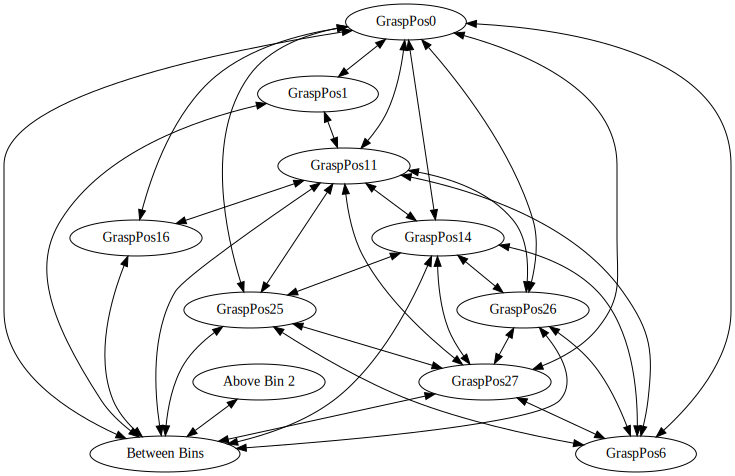

33


In [15]:

def VisualizeConnectivity(iris_regions):
    numEdges = 0

    graph = pydot.Dot("IRIS region connectivity")
    keys = list(iris_regions.keys())
    for k in keys:
        graph.add_node(pydot.Node(k))
    for i in range(len(keys)):
        v1 = iris_regions[keys[i]]
        for j in range(i + 1, len(keys)):
            v2 = iris_regions[keys[j]]
            if v1.IntersectsWith(v2):
                numEdges += 1
                graph.add_edge(pydot.Edge(keys[i], keys[j], dir="both"))
    display(SVG(graph.create_svg()))
    return numEdges
    
print(VisualizeConnectivity(iris_regions))


# Run GCS

In [23]:
#meshcat.Delete()

trajs = []

assert (
    seeds
), "The examples here use the 'manually-specified seeds' from the  section above. Please run that section first, or populate your own start and end configurations."
trajs.append(GcsTrajOpt(seeds["Transition"], newCand2, plantI, diagramI, robotI, objPos, obj))
#trajs.append(GcsTrajOpt(newCand2, oldRegPos, plantI, diagramI, robotI, objPos, obj))
linMoveTraj = PiecewisePose.MakeLinear([0, 0.5], [newCand1, oldCands[0]])
trajs.append(linMoveTraj)
trajs.append(GcsTrajOpt(oldRegPos, seeds["Above Bin 2"], plantI, diagramI, robotI, objPos, obj))

'''
PublishPositionTrajectory(
    trajs,
    diagramI.CreateDefaultContext(),
    plantI,
    diagramI.GetSubsystemByName("meshcat_visualizer(environment)"), robotI, objPos, obj, diagramI
)
'''

INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 17 rounding trials.


Running GCS
GCS solved in 47.8544225692749 seconds
Running GCS


INFO:drake:Solved GCS shortest path using CLP with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 15 rounding trials.


GCS solved in 63.3176851272583 seconds


'\nPublishPositionTrajectory(\n    trajs,\n    diagramI.CreateDefaultContext(),\n    plantI,\n    diagramI.GetSubsystemByName("meshcat_visualizer(environment)"), robotI, objPos, obj, diagramI\n)\n'

In [27]:

meshcat.Delete()
diagram, context, robot, objPos, obj, outPort, plant = make_environment_model_display(
    trajs, rng=np.random.default_rng(), num_ycb_objects=1, draw=True
)

context = diagram.CreateDefaultContext()

startPos = trajs[0].value(0)

plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, robot, startPos)

simulator = Simulator(diagram, context)
simulator.Initialize()
simulator.set_target_realtime_rate(0.5)
simulator.AdvanceTo(10.0)

'''

# Hide the planning gripper
meshcat.SetProperty("planning/gripper", "visible", False)

plant_context = plant.GetMyContextFromRoot(context)

PublishPositionTrajectory(
    trajs,
    diagram.CreateDefaultContext(),
    plant,
    diagram.GetSubsystemByName("meshcat_visualizer(environment)"), robot[0], objPos, obj, diagram
)
'''

['003_cracker_box.sdf', '004_sugar_box.sdf', '005_tomato_soup_can.sdf', '006_mustard_bottle.sdf', '009_gelatin_box.sdf', '010_potted_meat_can.sdf']


'\n\n# Hide the planning gripper\nmeshcat.SetProperty("planning/gripper", "visible", False)\n\nplant_context = plant.GetMyContextFromRoot(context)\n\nPublishPositionTrajectory(\n    trajs,\n    diagram.CreateDefaultContext(),\n    plant,\n    diagram.GetSubsystemByName("meshcat_visualizer(environment)"), robot[0], objPos, obj, diagram\n)\n'

In [32]:
context = diagram.CreateDefaultContext()

startPos = trajs[0].value(0)

plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, robot, startPos)

simulator = Simulator(diagram, context)
simulator.Initialize()
simulator.set_target_realtime_rate(0.5)
simulator.AdvanceTo(10.0)

DiffIK Testing

In [25]:
import math

plantIK, diagramIk = LoadRobotHardwareStation()

wsg = plantIK.GetModelInstanceByName("wsg")

gripper_frame = plantIK.GetBodyByName("body", wsg).body_frame()

contextIK = diagramIk.CreateDefaultContext()
plantContextIK = plantIK.GetMyContextFromRoot(contextIK)

jelloUpPos = [-2.28218173, 0.36183194, 0.6409329, -1.87001069, -0.25713113, 0.98730485, -1.4742302 ]

jelloUpPos[-1] += math.pi/2

oldPos = np.concatenate((jelloUpPos, [0,0]))

plantIK.SetPositions(plantContextIK, oldPos)

wsgPos = gripper_frame.CalcPoseInWorld(plantContextIK)
print(jelloUpPos)

[-2.28218173, 0.36183194, 0.6409329, -1.87001069, -0.25713113, 0.98730485, 0.09656612679489651]
